# Project 1, Part 5, Data Visualization



# Included Modules and Packages

Code cell containing your includes for modules and packages

In [1]:
import math
import numpy as np
import pandas as pd

import psycopg2

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [2]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)
    

In [3]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

# 1.5 Example of a Data Visualization created using Python

The data science team would like for you to create an example of a data visualization using Python from data in a Pandas dataframe containing data from an SQL query.

Write 1 and only 1 query.  Note that the query may have as many subqueries, including "with" clauses, as you wish.  Any query of your choosing.  You can write a query from scratch.  You can use a query from a previous problem in this project.  You can use a query from the labs.  The idea is to come up with a query whose resulting data will make for an excellent quality data visualization. 

Ensure that when you check this Juptyer Notebook into GitHub that the query results in the Pandas dataframe are clearly visible in GitHub.  Note: When a query result has a large number of rows, Pandas will only display the first 5 rows, a row with ellipses, and the last 5 rows. This is ok.

Once you have the data in a Pandas dataframe, you may write as much Python code and use as many code cells as you wish to produce the data visualization.

You may only use Python modules that are currently installed in the Anaconda Docker container.  You may not install additional modules or any other software.

All work must be done in Docker in your VM in AWS.  You may not use any external data visualization systems, such as Tableau, etc.

You may use any code from the labs to pattern your code after, however for the data visualization, you cannot wholesale copy a data visualization from the labs.

Ensure that it is properly titled, including titles for axes if present.

Ensure that when you check this Juptyer Notebook into GitHub that the data visualization is clearly visible.  

If you want to use Google Maps for your data visualization, this is fine, however, the image will not show up in GitHub.  So, just save the image to an image file, include it in the repo, and add a markdown cell to display the image file. Also with Google Maps, do NOT check gmap_api_key.txt into GitHub for security reasons.  If the grader needs to run it, they will supply their own gmap_api_key.txt.


In [26]:
rollback_before_flag = True
rollback_after_flag = True

query = """

WITH a AS (
SELECT
h.description AS holiday_name,
my_date::date AS date_analyzed,
EXTRACT(DOW FROM my_date::date) AS dow,
TO_CHAR(my_date::date, 'Day') AS day_of_week
    
FROM
generate_series('2020-01-01', '2020-12-31', '1 day'::interval) AS my_date
INNER JOIN holidays AS h ON my_date::date BETWEEN h.holiday_date - INTERVAL '7 days' AND h.holiday_date + INTERVAL '7 days'

WHERE
my_date::date BETWEEN '2020-01-01' AND '2020-12-31'
),

b AS (
SELECT
dow,
day_of_week,
ROUND(AVG(sales_dollars)) AS expected_sales_dollars
FROM (
        SELECT
        my_date::date AS sale_date,
        COALESCE(SUM(sa.total_amount), 0) AS sales_dollars,
        EXTRACT(DOW FROM my_date::date) AS dow,
        TO_CHAR(my_date::date, 'Day') AS day_of_week
        
        FROM
        generate_series('2020-01-01', '2020-12-31', '1 day'::interval) AS my_date
        INNER JOIN sales AS sa 
        ON my_date::date = sa.sale_date
        
        WHERE
        my_date::date BETWEEN '2020-01-01' AND '2020-12-31'
        
        GROUP BY my_date::date, dow, day_of_week
    ) AS daily_sales
    
    GROUP BY dow, day_of_week
),
c AS (
    WITH sales_data AS (
    SELECT
    my_date::date AS sale_date,
    COALESCE(SUM(sa.total_amount), 0) AS actual_sales_dollars
    
    FROM
    generate_series('2020-01-01', '2020-12-31', '1 day'::interval) AS my_date
    LEFT JOIN sales AS sa ON my_date::date = sa.sale_date
        
    WHERE
    my_date::date BETWEEN '2020-01-01' AND '2020-12-31'
    
    GROUP BY my_date::date
    ),
    closed_days AS (
    SELECT
    holiday_date AS sale_date,
    0 AS actual_sales_dollars
        
    FROM 
    holidays
        
    WHERE
    closed_flag = true
    AND holiday_date BETWEEN '2020-01-01' AND '2020-12-31'
    )
    SELECT * FROM sales_data
    UNION
    SELECT * FROM closed_days
)

SELECT
a.holiday_name,
a.date_analyzed,
a.day_of_week,
c.actual_sales_dollars,
b.expected_sales_dollars,
ROUND(c.actual_sales_dollars / b.expected_sales_dollars, 2) AS ratio_actual_expected

FROM a
LEFT JOIN b 
ON a.dow = b.dow
    
LEFT JOIN c 
ON a.date_analyzed = c.sale_date


ORDER BY
a.date_analyzed

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,holiday_name,date_analyzed,day_of_week,actual_sales_dollars,expected_sales_dollars,ratio_actual_expected
0,New Year's Day,2020-01-01,Wednesday,133776,263256,0.51
1,New Year's Day,2020-01-02,Thursday,261120,266051,0.98
2,New Year's Day,2020-01-03,Friday,263076,252522,1.04
3,New Year's Day,2020-01-04,Saturday,400368,373490,1.07
4,New Year's Day,2020-01-05,Sunday,394992,357482,1.10
...,...,...,...,...,...,...
167,Christmas,2020-12-27,Sunday,396096,357482,1.11
168,Christmas,2020-12-28,Monday,264852,253225,1.05
169,Christmas,2020-12-29,Tuesday,130440,132603,0.98
170,Christmas,2020-12-30,Wednesday,263424,263256,1.00


In [ ]:
# Use as many code cells as you need to create and display your data visualization


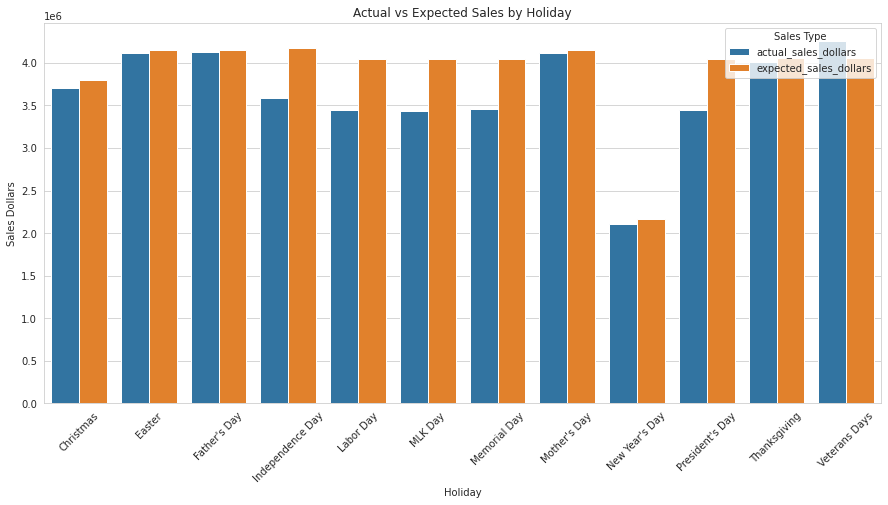

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregating data to calculate sums of actual and expected sales by holiday
df_agg = df.groupby('holiday_name').agg({
    'actual_sales_dollars': 'sum',
    'expected_sales_dollars': 'sum'
}).reset_index()

# Melting the DataFrame for easier plotting with seaborn
df_melted = df_agg.melt(id_vars=["holiday_name"], value_vars=["actual_sales_dollars", "expected_sales_dollars"],
                        var_name="sales_type", value_name="sales_dollars")

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting side-by-side bar plot of actual vs expected sales by holiday
plt.figure(figsize=(15, 7))
sns.barplot(x='holiday_name', y='sales_dollars', hue='sales_type', data=df_melted)
plt.xticks(rotation=45)
plt.xlabel('Holiday')
plt.ylabel('Sales Dollars')
plt.title('Actual vs Expected Sales by Holiday')
plt.legend(title='Sales Type', loc='upper right')
plt.show()
